💗 **DISEASES PREDICTION**

Heart disease remains the number-one killer in the world.

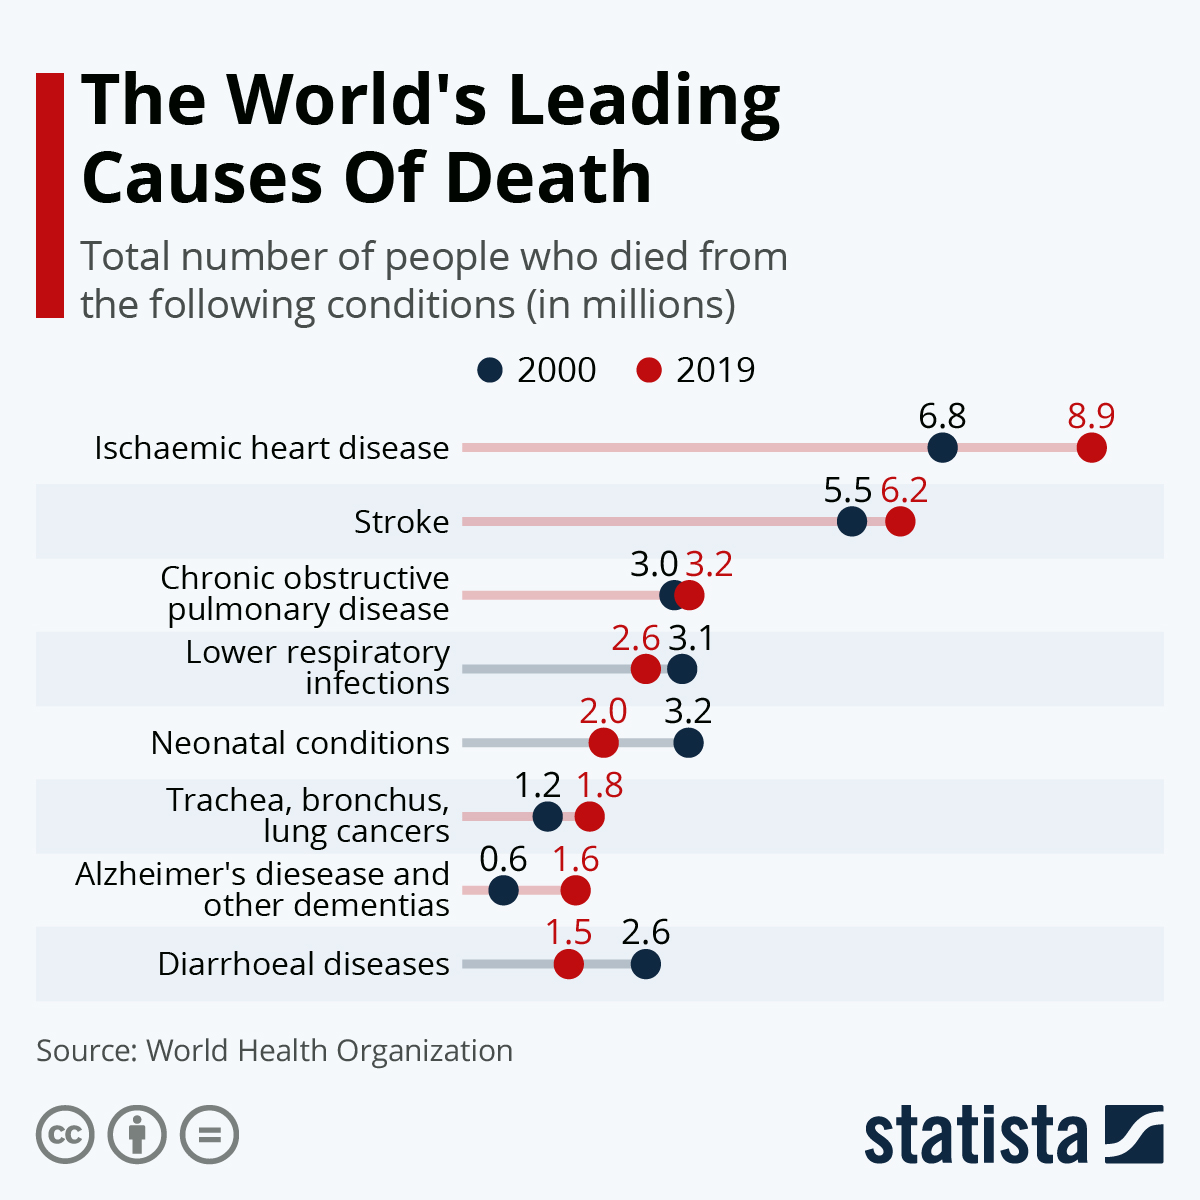

**The task is to predict the presence or absence of cardiovascular disease using the patient examination results.**

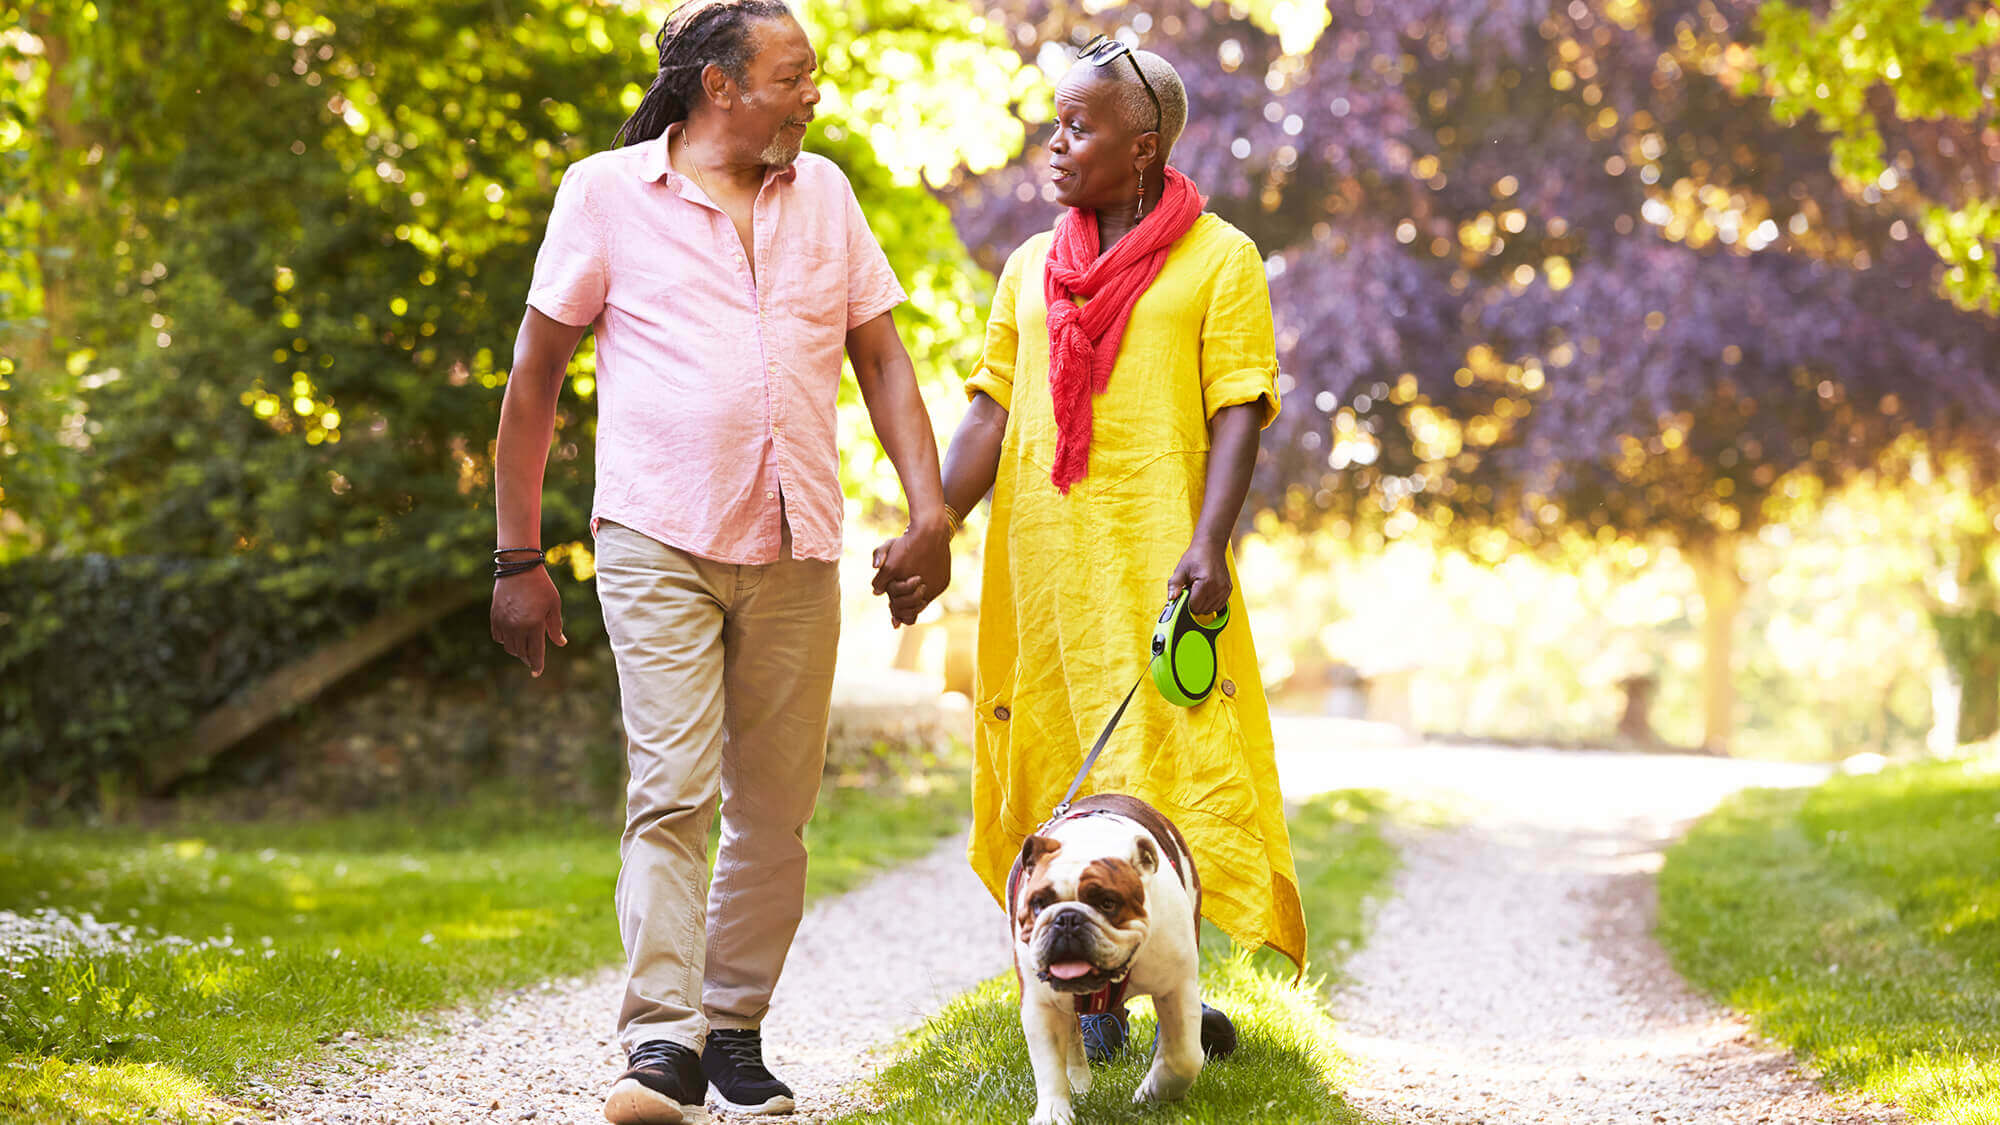

Source: American Heart Association


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install mlens

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
from pandas import set_option
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from mlens.visualization import corrmat
from sklearn.mixture import BayesianGaussianMixture
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from mlens.ensemble import SuperLearner
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

[MLENS] backend: threading


# Load data

In [4]:
train = pd.read_csv("/content/drive/MyDrive/train.csv", index_col="id")

In [5]:
test = pd.read_csv("/content/drive/MyDrive/test.csv", index_col="id")

# Preprocessing

In [6]:
test["gender"] -= 1
train["gender"] -= 1

In [7]:
train["age"] = train["age"] / 365.25
test["age"] = test["age"] / 365.25

In [8]:
def get_age_clusters():
    gm = BayesianGaussianMixture(n_components=13, random_state=1, max_iter=500, tol=0.0001)
    gm.fit(test.loc[test["age"] > 36, ["age"]].append(train.loc[train["age"] > 36, ["age"]]))
    centers = np.sort(gm.means_[:, 0])
    train["age"].append(test["age"])
    bins = [20] + list(np.array([[a, (a + b)/2] for a, b in zip(centers, centers[1:])]).flatten()) + [centers[-1], 66]
    return bins

In [9]:
age_clusters = get_age_clusters()

In [10]:
def preprocess(train, test):
    
    # ARTERIAL PRESSURE 
    
    train["ap_hi"] = train["ap_hi"].abs()
    test["ap_hi"] = test["ap_hi"].abs()
    train["ap_lo"] = train["ap_lo"].abs()
    test["ap_lo"] = test["ap_lo"].abs()
    train.drop(train.query("ap_hi < 10").index, axis=0, inplace=True)
    train.drop(train.query("ap_lo < 10").index, axis=0, inplace=True)
    train.loc[train["ap_hi"] < 20, "ap_hi"] = train["ap_hi"] + 10
    train.loc[train["ap_lo"] < 20, "ap_lo"] = train["ap_lo"] * 10
    train.loc[train["ap_hi"] < 30, "ap_hi"] = train["ap_hi"] + 100
    train.loc[train["ap_lo"] < 40, "ap_lo"] = train["ap_lo"] + 10
    train.loc[train["ap_lo"] < 40, "ap_lo"] = train["ap_lo"] + 10
    train.loc[train["ap_hi"] > 1000, "ap_hi"] = train["ap_hi"] / 10
    train.loc[train["ap_hi"] > 1000, "ap_hi"] = train["ap_hi"] / 10
    train.loc[train["ap_lo"] > 1000, "ap_lo"] = train["ap_lo"] / 10
    train.loc[train["ap_lo"] > 1000, "ap_lo"] = train["ap_lo"] / 10
    train.loc[train["ap_lo"] > 600, "ap_lo"] = train["ap_lo"] / 10
    train.loc[train["ap_lo"] > 200, "ap_lo"] = 60
    train.loc[train["ap_lo"] == train["ap_hi"], "ap_hi"] = 180
    train["ap_lo_dubl"] = train["ap_lo"]
    train["ap_hi_dubl"] = train["ap_hi"]
    train.loc[train["ap_lo"] > train["ap_hi"], "ap_lo"] = train["ap_hi_dubl"]
    train.loc[train["ap_lo_dubl"] > train["ap_hi"], "ap_hi"] = train["ap_lo_dubl"]
    train.loc[train["ap_hi"] < 85, "ap_hi"] = train["ap_hi"] + 10
    train.loc[train["ap_hi"] > 900, "ap_hi"] = train["ap_hi"] / 10
    train.loc[train["ap_hi"] > 500, "ap_hi"] = 170
    train.loc[train["ap_hi"] > 400, "ap_hi"] = 140
    train.loc[train.index == 56048, "ap_lo"] = 100
    train.loc[train.index == 50799, "ap_lo"] = 100
    train.loc[train.index == 30014, "ap_lo"] = 75
    train.loc[train.index == 30014, "ap_lo"] = 90
    test.loc[test["ap_hi"] < 10, "ap_hi"] = 140
    test.loc[test["ap_lo"] < 10, "ap_lo"] = test["ap_lo"] * 10
    test.loc[test["ap_lo"] < 10, "ap_lo"] = 80
    test.loc[test["ap_hi"] < 20, "ap_hi"] = test["ap_hi"] * 10
    test.loc[test["ap_lo"] < 19, "ap_lo"] = test["ap_lo"] * 10
    test["ap_hi_dubl"] = test["ap_hi"]
    test.loc[test["ap_hi"] < 80, "ap_hi"] = test["ap_lo"]
    test.loc[test["ap_hi"] < 80, "ap_hi"] = test["ap_hi"] + 100
    test.loc[test["ap_hi_dubl"] < 80, "ap_lo"] = test["ap_hi_dubl"]
    test.loc[test["ap_lo"] < 49, "ap_lo"] = test["ap_lo"] + 10
    test.loc[test["ap_lo"] < 49, "ap_lo"] = test["ap_lo"] + 10
    test.loc[test["ap_hi"] > 1000, "ap_hi"] = test["ap_hi"] / 10
    test.loc[test["ap_hi"] > 1000, "ap_hi"] = test["ap_hi"] / 10
    test.loc[test["ap_hi"] > 300, "ap_hi"] = 100
    test.loc[test["ap_lo"] >= 1000, "ap_lo"] = test["ap_lo"] / 10
    test.loc[test["ap_lo"] > 600, "ap_lo"] = test["ap_lo"] / 10
    test.loc[test["ap_lo"] > 300, "ap_lo"] = 70
    test["ap_lo_dubl"] = test["ap_lo"]
    test.loc[test["ap_lo"] > 140, "ap_hi"] = test["ap_lo"]
    test.loc[test["ap_lo_dubl"] > 140, "ap_lo"] = test["ap_hi_dubl"]
    test.loc[test.index == 78488, "ap_lo"] = 150
    test.loc[test.index == 78488, "ap_hi"] = 210
    test.loc[test["ap_lo"] == test["ap_hi"], "ap_hi"] = 140
    test.loc[test["ap_lo"] > test["ap_hi"], "ap_hi"] = test["ap_lo"] 
    test.loc[test["ap_lo"] == test["ap_hi"], "ap_lo"] = test["ap_hi_dubl"] 
    test.loc[test.index == 91106, "ap_lo"] = 90
    test.loc[test.index == 94426, "ap_lo"] = 110

    train.drop("ap_hi_dubl", axis=1, inplace=True)
    train.drop("ap_lo_dubl", axis=1, inplace=True)
    test.drop("ap_lo_dubl", axis=1, inplace=True)
    test.drop("ap_hi_dubl", axis=1, inplace=True)

    # HEIGHT AND WEIGHT

    train.loc[train["height"] < 100, "height"] = train["height"] + 100
    test.loc[test["height"] < 100, "height"] = test["height"] + 100
    train.loc[train["height"] < 140, "height"] = 140
    test.loc[test["height"] < 140, "height"] = 140
    train.loc[train["height"] == 250, "height"] = 150

    train.loc[train["weight"] <= 31, "weight"] = train["weight"] + 100
    test.loc[test["weight"] < 40, "weight"] = 40
    train.loc[train["weight"] < 40, "weight"] = 40

    # AGE

    train["age"] = (pd.cut(train["age"], bins=age_clusters, labels=False) + 39)
    test["age"] = (pd.cut(test["age"], bins=age_clusters, labels=False) + 39)    
   
    # FEATURE ENGINEERING

    train["pp"] = (train["ap_hi"]/5 - train["ap_lo"]/5).round()*5
    test["pp"] = (test["ap_hi"]/5 - test["ap_lo"]/5).round()*5

    train["ap_hi"], train["ap_lo"] = (train["ap_hi"]/5).round()*5, (train["ap_lo"]/5).round()*5
    test["ap_hi"], test["ap_lo"] = (test["ap_hi"]/5).round()*5, (test["ap_lo"]/5).round()*5
    
    return train, test

In [11]:
train, test = preprocess(train, test)

In [12]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Exploratory data analysis

Text(0, 0.5, 'ap_hi')

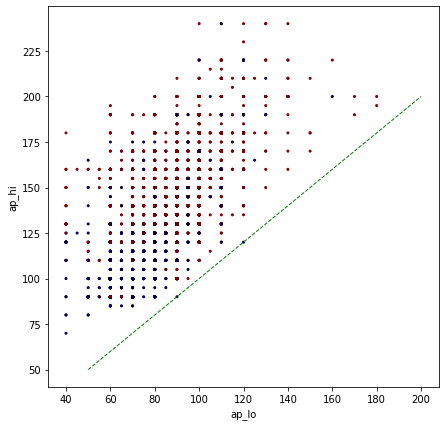

In [13]:
plt.figure(figsize=(7,7))
plt.scatter(train["ap_lo"], train["ap_hi"], s=4, c=train["cardio"], cmap="seismic")
plt.plot([50, 200], [50, 200], "--", linewidth=1, color="g")
plt.xlabel("ap_lo")
plt.ylabel("ap_hi")

# Feature engineering

- **Pulse pressure** tends to increase as you get older, and this number can also be an indicator of health problems before you develop symptoms.

- **Mean arterial pressure** is considered to be the perfusion pressure seen by organs in the body. So then high mean arterial pressur can cause CVD.

- Values of **blood pressure** can be classified by the Classification of office blood pressure and definitions of hypertension grade, published by European Society of Cardiology in 2019.

- For computing **BMI** I used the formula that was proposed by Nick Trefethen, Professor of numerical analysis at the University of Oxford.

- According to the International Journal of Obesity and Related Metabolic Disorders BMI may be converted into an estimate of **body fat percentage**.

- In 2006 Dr. Lemmens, Dr. Bernstein, and Dr. Brodsky discovered an equation that allows to predict **blood volume**. Changes in blood volume affect arterial pressure by changing cardiac output. An increase in blood volume increases arterial blood pressure. 

- According to the US National Institute of Health **diabetes** can cause CVD. High blood glucose from diabetes can damage your blood vessels and the nerves that control your heart and blood vessels. Over time, this damage can lead to heart disease. High cholesterol or glucose are signs of type 2 diabetes.

- In men, the risk profile of CDV increases linearly over time. Conversely, because estrogen has a beneficial effect on the cardiovascular system, women during the fertile age can be protected from atherosclerosis. However, after the **menopause** (mean age is 50) the incidence of stroke among women increases significantly.

In [14]:
def bp_func(row):
    s = row["ap_hi"]
    d = row["ap_lo"]
    if s >= 140 and d < 90:
        return  1
    if (s >= 140 or d >= 90) and (s <= 159 or d <=99):
        return 1
    if (s > 160 or d > 100) and (s <= 179 or d <= 109):
        return 1
    if s >= 180 or d >= 110:
        return 1
    return 0

In [15]:
def map_func(row):
    mean_arterial_pressure = row["mean_arterial_pressure"]
    if mean_arterial_pressure < 92:
        return 0
    if mean_arterial_pressure >= 92 and mean_arterial_pressure < 97:
        return 1
    return 1

In [16]:
def blood_volume_func(row):
    weight = row["weight"]
    bmi = row["bmi"]
    return (weight * 70) / ((bmi / 22) ** 0.5)

In [17]:
def bmi_func(row):
    bmi = row["bmi"]
    if bmi < 27:
        return 0
    return 1

In [18]:
def bfp_func(row):
    bfp = row["body_fat_percentage"]
    if bfp < 30:
        return 0
    return 1

In [19]:
def t2d_func(row):
    gluc = row["gluc"]
    chol = row["cholesterol"]
    if gluc > 2 or chol > 2:
        return 1
    return 0

In [20]:
def chol_func(row):
    chol = row["cholesterol"]    
    if chol > 1:
        return "high"
    return "normal"

In [21]:
def gluc_func(row):
    gluc = row["gluc"]    
    if gluc > 1:
        return "high"
    return "normal"

In [22]:
def menopause_func(row):
    male = row["gender"]
    age = row["age"]
    if male == False and age > 50:
        return 1
    return 0

In [23]:
def feature_engineering(train, test):

    # ARTERIAL PRESSURE 

    train["bp_normal"] = ((train["ap_hi"].between(85, 125)) & (train["ap_lo"].between(55, 85))).astype("int")
    test["bp_normal"] = ((test["ap_hi"].between(85, 125)) & (test["ap_lo"].between(55, 85))).astype("int")

    train["cat_bp"] = train.apply(bp_func, axis=1)
    test["cat_bp"] = test.apply(bp_func, axis=1)

    train["alt_pp"] = ((train["ap_hi"] - train["ap_lo"]) / train["ap_hi"]) * 100
    test["alt_pp"] = ((test["ap_hi"] - test["ap_lo"]) / test["ap_hi"]) * 100

    train["mean_arterial_pressure"] = train["ap_lo"] + ((1/3) * (train["ap_hi"] - train["ap_lo"]))
    test["mean_arterial_pressure"] = test["ap_lo"] + ((1/3) * (test["ap_hi"] - test["ap_lo"]))

    train["cat_map"] = train.apply(map_func, axis=1)
    test["cat_map"] = test.apply(map_func, axis=1)

    #BMI

    train["bmi"] = 1.3 * (train["weight"] / ((train["height"] / 100) ** 2.5))
    test["bmi"] = 1.3 * (test["weight"] / ((test["height"] / 100) ** 2.5))

    train["blood_volume"] = train.apply(blood_volume_func, axis=1)
    test["blood_volume"] = test.apply(blood_volume_func, axis=1)

    train["cat_bmi"] = train.apply(bmi_func, axis=1)
    test["cat_bmi"] = test.apply(bmi_func, axis=1)

    train["alt_bmi"] = pd.qcut(train["weight"]/(train["height"]/100)**2, 25, labels=False)
    test["alt_bmi"] = pd.qcut(test["weight"]/(test["height"]/100)**2, 25, labels=False)

    train["cat_weight"] = pd.qcut(train["weight"], 10, labels=False)
    test["cat_weight"] = pd.qcut(test["weight"], 10, labels=False)

    train["body_fat_percentage"] = (1.39 * train["bmi"]) + (0.16 * train["age"]) - (10.34 * train["gender"]) - 9
    test["body_fat_percentage"] = (1.39 * test["bmi"]) + (0.16 * test["age"]) - (10.34 * test["gender"]) - 9

    train["obesity_bfp"] = train.apply(bfp_func, axis=1)
    test["obesity_bfp"] = test.apply(bfp_func, axis=1)

    #CHOLESTEROL AND GLUCOSE

    train["t2d"] = train.apply(t2d_func, axis=1)
    test["t2d"] = test.apply(t2d_func, axis=1)

    train["cholesterol"] = train.apply(chol_func, axis=1)
    test["cholesterol"] = test.apply(chol_func, axis=1)

    train["gluc"] = train.apply(gluc_func, axis=1)
    test["gluc"] = test.apply(gluc_func, axis=1)

    #MENOPAUSE

    train["menopause"] = train.apply(menopause_func, axis=1)
    test["menopause"] = test.apply(menopause_func, axis=1)

    return train, test

In [24]:
train, test = feature_engineering(train, test)

In [25]:
train_ohe = pd.get_dummies(train)
test_ohe = pd.get_dummies(test)

In [26]:
train_ohe.drop(["cholesterol_normal", "gluc_normal"], axis=1, inplace=True)
test_ohe.drop(["cholesterol_normal", "gluc_normal"], axis=1, inplace=True)

# Prediction of smoke and alco

- Alcohol consumption and smoking are subjective features that are difficult to trust. So then it is necessary to predict these features.

In [27]:
train_sa = train_ohe.drop(["alco", "smoke", "cardio"], axis=1)
test_sa = test_ohe.drop(["alco", "smoke"], axis=1)
alco = train_ohe["alco"]
smoke = train_ohe["smoke"]

In [31]:
xgb_model_sa = XGBClassifier(max_depth=4, learning_rate=0.02, n_estimators=800,
                      reg_lambda=6.2, reg_alpha=0.6288, subsample=0.8019,
                      colsample_bylevel=0.6983, colsample_bytree=0.7464,
                      gamma=0.9215, min_child_weight=6.5, max_delta_step=0.5,
                      seed=5, nthread=-1)

In [29]:
def over_sampling(X, y):
    over_sampler = RandomOverSampler(sampling_strategy="minority", random_state=1)
    X_over, y_over = over_sampler.fit_resample(X, y)
    return X_over, y_over

In [30]:
def under_sampling(X, y):
    under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
    X_under, y_under = under_sampler.fit_resample(X, y)
    return X_under, y_under

In [32]:
def smoke_alco(X_train, y, X):
    xgb_model_sa.fit(X_train, y)
    pr = xgb_model_sa.predict(X)
    return pd.Series(pr)

In [33]:
train_alco_over, alco_over = over_sampling(train_sa, alco)
train_smoke_under, smoke_under = under_sampling(train_sa, smoke)

In [34]:
train_ohe["alco"] = smoke_alco(train_alco_over, alco_over, train_sa)
train_ohe["smoke"] = smoke_alco(train_smoke_under, smoke_under, train_sa)

In [35]:
train_ohe["smoke"].value_counts(normalize=True)

0    0.723631
1    0.276369
Name: smoke, dtype: float64

According to the WHO the prevalence of current adult smokers (15 and above) in Kazakhstan in 2014 was 22.4%. 

In [36]:
train_ohe["alco"].value_counts(normalize=True)

0    0.65237
1    0.34763
Name: alco, dtype: float64

According to the Survey on drug use and health in Kazakhstan in 2018, 35 percent of Kazakhstan’s population drink alcohol.

In [37]:
test_ohe["alco"] = smoke_alco(train_alco_over, alco_over, test_sa)
test_ohe["smoke"] = smoke_alco(train_smoke_under, smoke_under, test_sa)

# Feature correlation

In [38]:
features = ["ap_hi", "mean_arterial_pressure", "ap_lo", "age", "bmi", "weight", "pp", "body_fat_percentage", 
            "blood_volume", "obesity_bfp", "t2d", "menopause", "gluc_high", "alt_bmi", "alco", "smoke", "active",
            "cat_weight", "alt_pp", "cholesterol_high", "bp_normal", "cat_map", "cat_bmi", "cat_bp"]

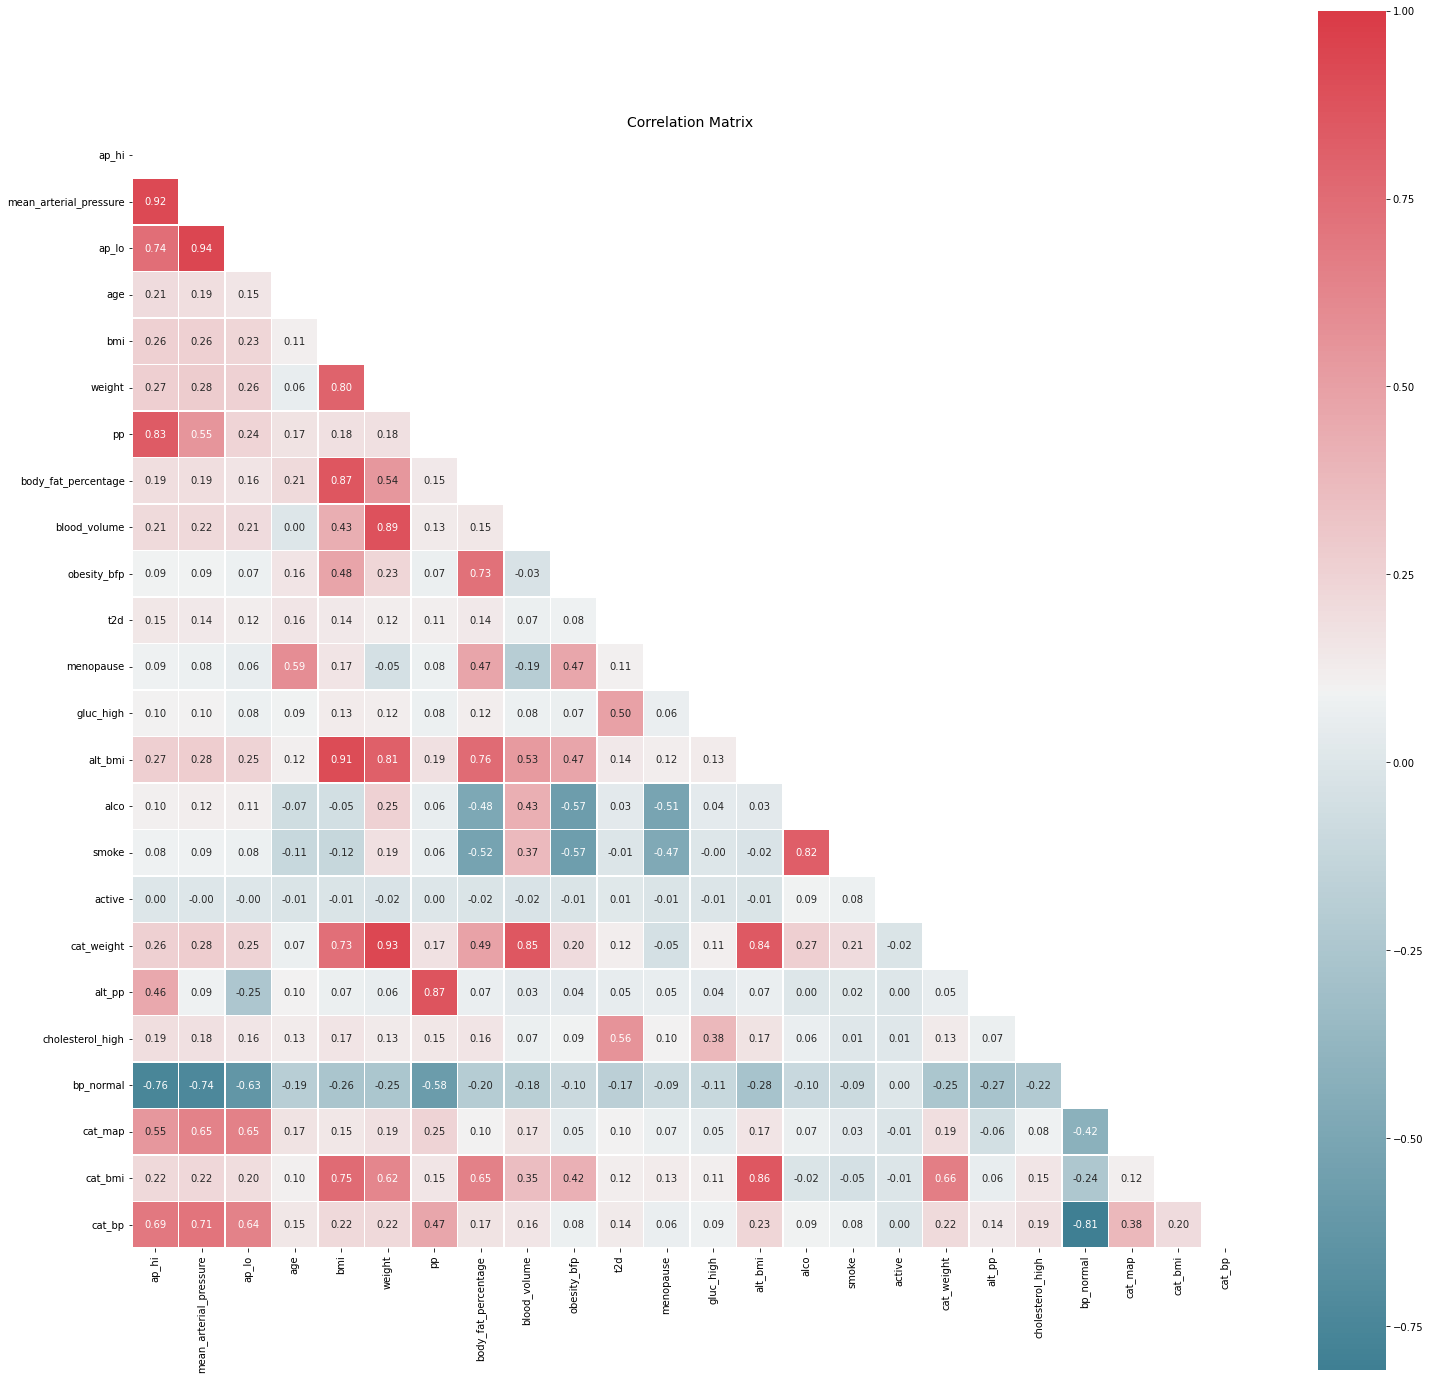

In [39]:
corrmat(train_ohe[features].append(test_ohe[features]).corr(), figsize=(25, 25), inflate=False)

In [40]:
train_corr = train_ohe.corr()["cardio"]
train_corr.abs().sort_values(ascending=False)[1:]

ap_hi                     0.431546
bp_normal                 0.423978
mean_arterial_pressure    0.413321
cat_bp                    0.394177
ap_lo                     0.345678
pp                        0.336455
cat_map                   0.263270
age                       0.235625
cholesterol_high          0.205453
alt_bmi                   0.199153
bmi                       0.186884
weight                    0.181562
cat_weight                0.180755
t2d                       0.173991
alt_pp                    0.171028
body_fat_percentage       0.167869
cat_bmi                   0.164528
menopause                 0.134443
blood_volume              0.130468
obesity_bfp               0.101696
gluc_high                 0.090768
active                    0.035589
alco                      0.032654
smoke                     0.016497
height                    0.012535
gender                    0.008186
Name: cardio, dtype: float64

# Base lines



In [ ]:
X = train_ohe[features]
y = train_ohe["cardio"]
test = test_ohe[features]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
test = scaler.transform(test)

In [ ]:
def models_func():
    models = []
    
    models.append(("LR" , LogisticRegression()))
    models.append(("SGD" , SGDClassifier()))
    models.append(("KNN" , KNeighborsClassifier()))
    models.append(("LDA" , LinearDiscriminantAnalysis()))
    models.append(("GNB" , GaussianNB()))
    models.append(("BNB" , BernoulliNB()))
    models.append(("Ada" , AdaBoostClassifier()))
    models.append(("GB" , GradientBoostingClassifier())) 
    models.append(("RF" , RandomForestClassifier()))
    models.append(("ET" , ExtraTreesClassifier()))
    models.append(("XGB" , XGBClassifier()))
    models.append(("LGB" , LGBMClassifier()))
    
    return models

In [ ]:
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)

In [ ]:
def base_model_func(X, y, models):
    scoring = "roc_auc"
    results = []
    names = []
    for name, model in models:
        kfold = kf
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f" % (name, cv_results.mean())
        print(msg)
        
    return names, results

In [ ]:
models = models_func()
names, results = base_model_func(X, y, models)

LR: 0.792954
SGD: 0.779717
KNN: 0.744515
LDA: 0.791067
GNB: 0.778677
BNB: 0.769275
Ada: 0.794452
GB: 0.801758
RF: 0.762647
ET: 0.737194
XGB: 0.801570
LGB: 0.801537


Gradient Boosting, GB and LGB models showed the best results.

# Hyperparameters tuning

 The following hyperparameters were found using GridSearchCV.

In [41]:
rf_params = {"max_depth": 8,
             "max_features": 7,
             "min_samples_split": 10,
             "n_estimators": 500}

In [42]:
knn_params = {"n_neighbors": 20}

In [43]:
ada_params = {"learning_rate": .1,
              "n_estimators": 300}

In [44]:
gb_params = {"n_estimators": 300,
             "learning_rate": .1,
             "min_samples_split": 0.1,
             "max_depth": 3}

In [45]:
lgbm_params = {"learning_rate": .01,
               "n_estimators": 1000,
               "max_depth": 5}

In [46]:
xgb_params = {"n_estimators": 500,
              "max_depth": 3,
              "learning_rate ": .01}

In [47]:
et_params = {"n_estimators": 300,
             "max_depth": 6,
             "min_samples_split": 2}

In [48]:
nb_params = {"var_smoothing": 1.873817422860387e-09}

# Stacking

In [49]:
def get_models():

    rf_model = RandomForestClassifier(**rf_params)

    knn_model = KNeighborsClassifier(**knn_params)

    nb_model = GaussianNB(**nb_params)

    ada_model = AdaBoostClassifier(**ada_params)

    gb_model = GradientBoostingClassifier(**gb_params)

    lgbm_model = LGBMClassifier(**lgbm_params)

    xgb_model = XGBClassifier(**xgb_params)

    lg_model = LogisticRegression()
    
    sgd_model = SGDClassifier(loss="log", penalty="l1")

    lda_model = LinearDiscriminantAnalysis()
    
    et_model = ExtraTreesClassifier(**et_params)

    models = {"RF": rf_model, "KNN": knn_model, "NB": nb_model, 
              "Ada": ada_model, "GB": gb_model, "LGBM": lgbm_model, 
              "XGB": xgb_model, "LG": lg_model, "SGD": sgd_model, 
              "LDA": lda_model, "ET": et_model}

    return models

In [ ]:
base_learners = get_models()
meta_learner = LogisticRegression()

In [ ]:
sl = SuperLearner(random_state=1)

sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

In [ ]:
results = cross_val_score(sl, X, y, cv=kf, scoring="roc_auc")

In [ ]:
sl.fit(X, y)
p_sl = sl.predict_proba(test)

# Model evaluation

In [ ]:
meta_learner.fit(X, y)

In [ ]:
result = permutation_importance(meta_learner, X, y, scoring="roc_auc")

In [ ]:
result_sorted = result.importances_mean.argsort()

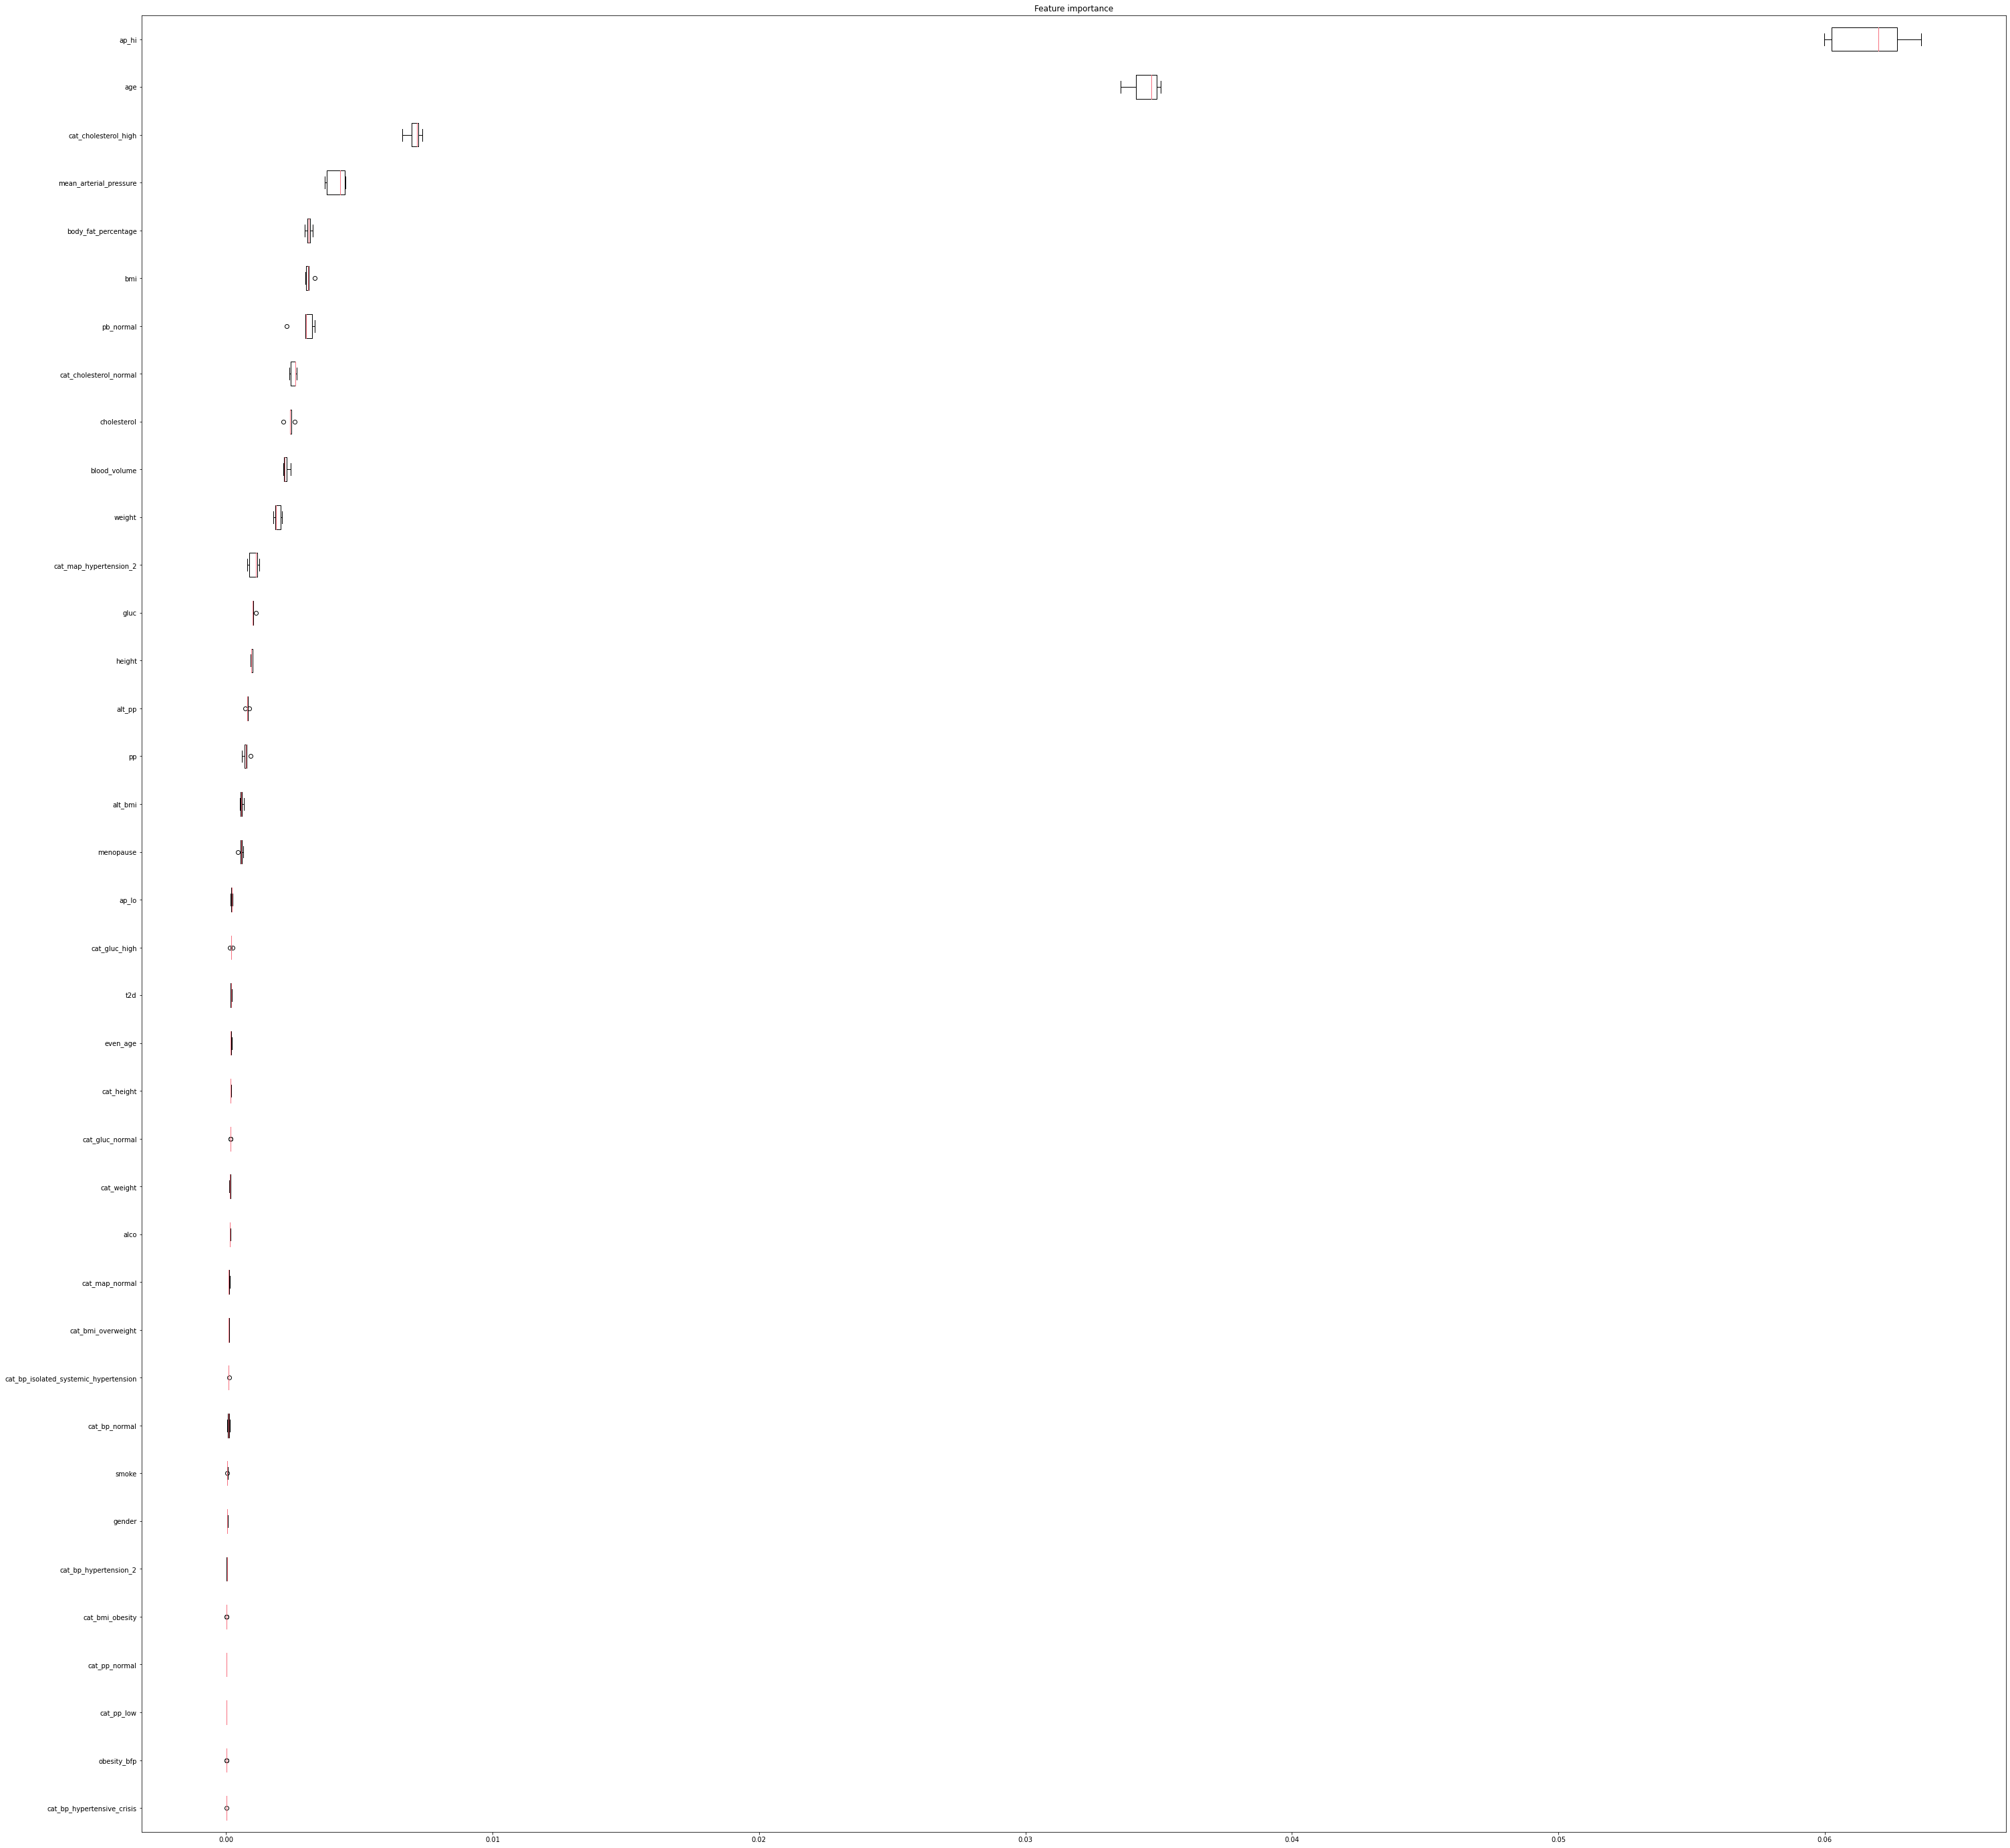

In [ ]:
fig, ax = plt.subplots(figsize=(50,50))
ax.boxplot(result.importances[result_sorted].T, vert=False, labels=X.columns[result_sorted])
plt.title("Feature importance")
plt.show()

# Testing

In [ ]:
test2 = pd.read_csv("/content/drive/MyDrive/test.csv", index_col="id")

In [ ]:
data = pd.concat([pd.Series(test2.index), pd.Series(p_vot[:, 1])], axis="columns")

In [ ]:
data.set_index("id", inplace=True)

In [ ]:
data.rename(columns = {0: "cardio"}, inplace=True)

In [ ]:
data.to_csv("cardio.csv")